# Joint Probabilistic Data Association

This notebook is the implementation of PDA algorithm for single target tracking algorithm.
The terminology used in this file is listed as below

You are tracking the traget x in a discrete time space, at time t = k
- track: $x_k$
- observation: $z_k$, with total $m_k$ elements in time k
- accumualted observation: $Z^k = \{z_1, z_2, ..., z_k\}$

The pseudocode for JPDA is the following based on [here](https://www.youtube.com/watch?v=qq6a04je9ck&list=PLadnyz93xCLiHWjLcLFdzc-SidNL1kRF7&index=18):

for ith track

1. Implementing the gating (ellipsoidal gating) to capture all obs inside this gate $z_k^i$

2. For the obs inside ith gate, check if the obs is joint with other gates; and joint all tracks joint with ith track.

3. Build hypothesis matrix for all aforementioned gates, the calculate the probability of all hypothesis inside the hypothesis matrix

4. Inside the hypothesis matrix, $\forall z \in z_k^i$, pick up and sum all prob of hypothesis involves z inside gate i (also false alarm), forms the weight list, and normalize it as $w_k^i = \{w_k^i(z); z \in z_k^i\}$.

5. update the KF for ith track by the following (PDA approach) approach


$$    
\bar{x}_{i, k|k}^{PDA} = \sum_{z \in z_k^i}^{} w_k^i(z)\hat{x}_{i, k}^z
$$

$$
P_{i, k|k}^{PDA} = \sum_{z \in z_k^i}^{} w_k^i(z) P_{i, k}^z + w_k^i(z)(\bar{x}_{i, k|k}^{PDA} - \hat{x}_{i, k}^z)(\bar{x}_{i, k|k}^{PDA} - \hat{x}_{i, k}^z)^T
$$


here $\hat{x}_{i, k}^z, P_{i, k}^z$ means the ith KF in k-1 time set updated with observation z.

## 1. Generate observation data
Now first let's get some inputs. We simulate some random points plus a sin wave trajectory in 2D Cartesian space.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.linalg
from numpy.linalg import inv
import copy
from scipy.stats import multivariate_normal
from scipy.stats.distributions import chi2

Here we will have 3 tracking for 3 objects doing:
    1. sin wave movement
    2. linear movement
    3. Parabola

In [3]:
input_var = 0.1
dt = 0.1
time_range = np.linspace(dt, 10, 100)

obs_list = []
random.seed(1)
for t in time_range:
    # the sin wave signal
    z_k = []
    point_sin = [t * 3 + 0.1 * np.random.normal(0, input_var), 3 + 3 * np.sin(t * 3) + 0.1 * np.random.normal(0, input_var)]
    z_k.append(point_sin)
    
    z_k.append([3 * t +  np.random.normal(0, input_var),  t - 5 +  np.random.normal(0, input_var)])
    
    z_k.append([15 + 4 * np.cos(t) + 0.1 * np.random.normal(0, input_var),  4 * np.sin(t) + 0.1 * np.random.normal(0, input_var)])
    
    for i in range(random.randint(5, 10)):
        ran_point = [30* random.random(), 20 * random.random() - 10]
        z_k.append(ran_point)
        
    obs_list.append(z_k)

Show the data generated in plot

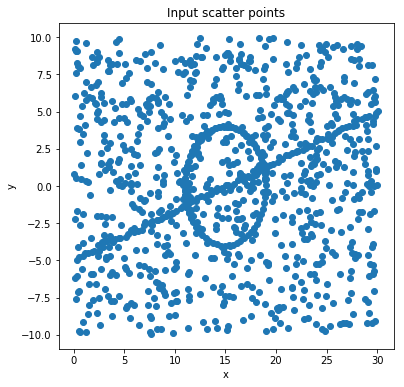

In [4]:
points = []
for z_k in obs_list:
    for point in z_k:
        points.append(point)

points = np.array(points)
plt.figure(figsize=(6,6))
# plt.plot(np.arange(N)*dt,kal,'b')
plt.scatter(points[:, 0], points[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Input scatter points')
plt.show()

show the dynamic process

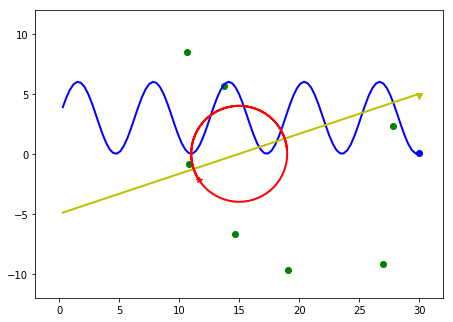

In [13]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 32), ylim=(-12, 12))

real_point1, = ax.plot([], [], 'bo', ms=6)
real_point2, = ax.plot([], [], 'yv', ms=6)
real_point3, = ax.plot([], [], 'r*', ms=6)
rand_point, = ax.plot([], [], 'go', ms=6)
obs_list_anim = np.array(obs_list)
line1, = ax.plot([], [], lw=2, color = 'b')
line2, = ax.plot([], [], lw=2, color = 'y')
line3, = ax.plot([], [], lw=2, color = 'r')

def init():
    """initialize animation"""
    
    real_point1.set_data([], [])
    real_point2.set_data([], [])
    real_point3.set_data([], [])
    rand_point.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return real_point1, real_point2, real_point3, rand_point, line1, line2, line3

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    
    real_point1.set_data(obs_list_anim[i][0][0], obs_list_anim[i][0][1])
    real_point2.set_data(obs_list_anim[i][1][0], obs_list_anim[i][1][1])
    real_point3.set_data(obs_list_anim[i][2][0], obs_list_anim[i][2][1])
    x , y = [], []
    for point in obs_list_anim[i][3:]:
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
    
    line1.set_data(3*time_range, 3 + 3 * np.sin(3*time_range))
    line2.set_data(3*time_range, time_range - 5)
    line3.set_data(15 + 4 * np.cos(time_range), 4 * np.sin(time_range))
    
    return real_point1, real_point2, real_point3, rand_point

ani = animation.FuncAnimation(fig, animate, frames=len(obs_list),
                              interval=10, blit=True, init_func=init)

ani.save('video/jpda_obs.mp4', fps=3)

## 2. Implement the JPDA based on our observation data

### 2.1 Setup Kalman Filter

For kalman filter, we have state function

\begin{align}
    x_k &= F_{k-1}x_{k-1} + v_{k-1} \label{eq1} \\
    z_k &= H_kx_k \label{eq2}
\end{align}


The predict step is

\begin{align}
    \hat{x}_{k|k-1} &= F_{k-1}\hat{x}_{k-1|k-1} \label{a} \\
    P_{k|k-1} &= F_{k|k-1}P_{k-1|k-1}F_{k|k-1}^T + Q_{k-1} \label{b} 
\end{align}



The update step is

\begin{align}
    \tilde{z}_k &= z_k - H_{k-1}\hat{x}_{k|k-1} \label{c} \\
    S_k &= H_kP_{k|k-1}H_k^T + R_k \label{d} \\
    K_k &= P_{k|k-1}H_kS_k^{-1} \label{e} \\
    \hat{x}_{k|k} &= \hat{x}_{k|k-1} + K_k\tilde{z}_k \label{f} \\
    P_{k|k} &= (I - K_kH_k)P_{k|k-1} \label{ge} 
\end{align}


In [5]:
class EKFcontrol():
    # here actually a standard Linear KF is implemented 
    def __init__(self, _F,_H,_x,_P,_Q,_R):
        
        self.F=_F
        self.H=_H
        
        self.x_k_k_min=_x
        self.P_k_k_min=_P
        self.Q=_Q
        self.R=_R
        
        self.x_k_k=_x
        self.P_k_k=_P
        
        self.x_dim = _x.shape[0]
        self.z_dim = _H.shape[1]
        
        self.S_k = self.R
    
    def getCurrentState(self):
        return self.x_k_k_min
    
    def getEst(self):
        return np.dot(self.H, self.x_k_k)
    
    def predict(self):
        self.x_k_k_min = np.dot(self.F, self.x_k_k)
        self.P_k_k_min = np.dot(self.F, np.dot(self.P_k_k,self.F.T)) + self.Q
        
    def update(self,z):
        z = np.matrix(z).T

        self.z_bar = np.dot(self.H, self.x_k_k_min)
        self.z_res = z - self.z_bar
        self.S_k = np.dot(np.dot(self.H, self.P_k_k_min), self.H.T) + self.R
        K_k = np.dot(self.P_k_k_min, self.H.T) * inv(self.S_k)
        self.x_k_k = self.x_k_k_min + np.dot (K_k, self.z_res)
        self.P_k_k = np.dot(np.eye(self.x_dim) - np.dot(K_k, self.H), self.P_k_k_min)

def lambda_c(z_k):
    N = len(z_k)   # pda
    V = 300   # volume of obs region
    return N / V

def cal_beta(N):
    # TODO Don't define the beta yet
#     normalized volume for ellipsodial gate is 
    V = np.pi * gating_size  # equ. 6.28 b
    
    
    return N / V

def normalize(a_list):
    the_sum = sum(a_list)
    a_list = a_list / the_sum
    return a_list

def elliposidualGating(z_til, S):
    
    value = np.dot(np.dot(z_til.T, inv(S)), z_til)[0,0]
    
    if value <= gating_size:
        return 1
    else:
        return 0


def checkIfDuplicates(listOfElems):
    ''' Check if given list contains any duplicates '''    
    setOfElems = set()
    # special case, all are false alarm, so the sum should be len * -1
    sum_ = sum(listOfElems)
    if sum_ ==  - len(listOfElems):
        return True

    for elem in listOfElems:
        if elem in setOfElems:
            return True
    
        else:
            setOfElems.add(elem)         
    return False



def common_fact(beta, P_D, N_T, N_o):
    if N_o > N_T:
        return beta ** (N_o - N_T)
    else:
        return (1 - P_D) ** (N_T - N_o)

class measurement:
    def __init__(self, z, id_):
        self.value = z
        self.track = []
        self.g_ij = []
        self.table = {"track": self.track, "g_ij": self.g_ij}
        self.id = id_
        
    def inside_track(self, track_id):
        self.track.append(track_id)

class track:
    def __init__(self, id_):
        self.id = id_
        self.measurement = []
    
    def get_measurement(self, a_list):
        # here a_list is np.ndarray data type from np.where func
        self.measurement += a_list.tolist()
        return


## 2.2 Implement JPDA Algorithm

In [8]:
# Define gating size, for elliposidal gating, we need parameter P_G
P_G = 0.95
global gating_size 
gating_size = chi2.ppf(P_G, df = 2)
track_list = []

P_D = 0.9

x0_list = [np.matrix([0, 3, 0, 0]).T, np.matrix([0, -5, 0, 0]).T, np.matrix([19, 0, 0, 0]).T]


F = np.matrix([[1, 0, dt, 0],
                [0, 1, 0, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# kf.B=np.array([[1]])
H=np.matrix([[1, 0, 0, 0],
                [0, 1, 0, 0]])

Q=np.diag([0.1, 0.1, 0.1, 0.1])
P = Q
R=np.diag([0.1, 0.1])

for x0 in x0_list:
    track_list.append(EKFcontrol(F, H, x0, P, Q, R))

# perdict first
for kf in track_list:
    kf.predict()
    
z_k = obs_list[0]

n = len(track_list)

jpda_est = []


for z_k in obs_list:

    ############################## obs loop starts
    # 1. extract all obs inside elliposidual gate

    jpda_k_est = []

    obs_matrix = np.zeros((len(track_list), len(z_k)))


    for i in range(len(track_list)):
        kf = track_list[i]
        S = np.dot(np.dot(kf.H, kf.P_k_k_min), kf.H.T) + kf.R
        pred_z = np.dot(kf.H, kf.x_k_k_min)

        for j in range(len(z_k)):
            z = z_k[j]
            z_til = pred_z - np.matrix(z).T
            
            obs_matrix[i][j] = elliposidualGating(z_til, S)

    # create a mitrix to check the relationship between obs and measurements


    obs_sum = obs_matrix.sum(axis=0)
    # matrix operation, exclude all observations whose sum is 0, which means its not in any gate
    index = np.where(obs_sum > 0)[0]

    # obs inside the gate -- z_k_gate
    # z_k_gate = np.array(z_k)
    # z_k_gate = z_k_gate[index]

    # obs matrix inside the gate -- obs_matrix_gate
    obs_matrix_gate = obs_matrix[:, index]

    # 2. initialize each observation
    obs_class = []
    # now in obs_class, each element is a class with its .track includes all track numbers from 0 - m_k
    # then we need to analyse the gate. First for jth obs z_j in its ith gate we need to calculate
    # g_ij = N(z_j - z_ij|0, S_ij) here z_ij and S_ij is the updated KF given observation z_j

    
    for i in range(len(z_k)):

        if i in index:
            a_mea = measurement(z_k[i], i)
            for j in np.where(obs_matrix[:, i] != 0)[0]:
                # j is the track id for obs i, in obs_matrix the column is not 0
                a_mea.inside_track(j)
                temp_kf = copy.deepcopy(track_list[j])
                temp_kf.update(z_k[i])
                var = multivariate_normal(mean=np.squeeze(temp_kf.z_bar.reshape(2).tolist()[0]), cov=temp_kf.S_k)
                a_mea.g_ij.append(var.pdf(z_k[i]))
            obs_class.append(a_mea)
        else:
            obs_class.append([])
    # 3. for each gate/track, analysis if there exists observations joint different tracks, find out the relation between different tracks
    
    
    track_class = []
    for i in range(n):
        a_track = track(i)
        a_track.get_measurement(np.where(obs_matrix[i] != 0)[0])
        a_track.measurement.append(-1)
        track_class.append(a_track)



    for i in range(n):
        # print("loop for ", i, "th track")

        # calculate the beta for ith track
        # need the number of measurements inside the gate
        beta = cal_beta(len(track_class[i].measurement) - 1)

        # track_remain.remove(i)
        table_key = [i]

        
        
        # begin find all observations inside this gate that is related to other gates (joint)
        
        for obs_id in track_class[i].measurement:
            if obs_id != -1:
                obs = obs_class[obs_id]
                table_key += obs.track
            
        table_key = list(set(table_key))
        # for each track, figure out how many observations inside the track
        obs_num_tracks = obs_matrix.sum(axis=1)[table_key]

        # number of joint tracks
        N_T = len(table_key)
        # number of observations total
        total_obs = []
        for track_id in table_key:
            a_track = track_class[track_id]
            total_obs +=a_track.measurement

        total_obs = list(set(total_obs))
        N_o = len(total_obs) - 1

        common_factor = common_fact(beta, P_D, N_T, N_o)

        # after merged all related tracks, we generat a hypothesis matrix/table based on the table 
        # generated by the table_key
        obs_num_tracks_ = obs_num_tracks + 1
        total_row = int(obs_num_tracks_.prod())

        # create title for the table


        hyp_matrix = {}
        for a_key in table_key:
            hyp_matrix[str(a_key)] = []
        hyp_matrix["p"] = []
        
        for row_num in range(total_row):
            key_num = len(table_key)
            col_num = 0
            # build one row of hypothesis
            while key_num > 0:
                if col_num == len(table_key) - 1:
                    obs_id = int(row_num)
                    product = 1
                else:
                    product = obs_num_tracks_[(col_num + 1):].prod()
                    obs_id = int(row_num // product)
                
                
                value = track_class[table_key[col_num]].measurement[obs_id]
                
                key = str(table_key[col_num])
                hyp_matrix[key].append(value)
                row_num = row_num % product
                col_num += 1
                key_num -= 1
            
            # now we want to calculate the probability of this row's hypothesis
            hyp_list = []

            prob = common_factor
            for key in hyp_matrix.keys():
                if key != 'p':
                    hyp_list.append(hyp_matrix[key][-1])
            
            # print('hyp_list, ', hyp_list)
            # calculate the prob of this hypothesis
            if checkIfDuplicates(hyp_list):
                # this is not one vaild hypothesis.
                prob = 0
            else:
                # this is the valid hypothesis, we should calculate the prob
                for key in hyp_matrix.keys():
                    if key != 'p':
                        track_id = int(key)
                        obs_id = hyp_matrix[key][-1]
                        # print('obs id ', obs_id)
                        if obs_id == -1:
                            prob *= (1 - P_D) * beta
                        else:
                            # print(obs_class[obs_id].table, print(obs_class[obs_id].id))
                            index = obs_class[obs_id].track.index(track_id)
                            prob *= P_D * obs_class[obs_id].g_ij[index]
            hyp_matrix['p'].append(prob)
            
        # 4. Then gather the prob in this track, and update the kF
        obs_in_i_track = track_class[i].measurement
        obs_in_i_track_prob = []
        hyp_in_i_track = np.array(hyp_matrix[str(i)])
        hyp_in_i_track_prob = np.array(hyp_matrix['p'])
        for obs in obs_in_i_track:
            index_ = np.where(hyp_in_i_track == obs)
            w_ij_list = hyp_in_i_track_prob[index_]
            obs_in_i_track_prob.append(w_ij_list.sum())
        
        # then normalize all w_ij s
        obs_in_i_track_prob_norm = normalize(obs_in_i_track_prob)

        # well, we then just need to update the KF of ith track
        kf = track_list[i]
        x_k = []
        P_k = []
    
        # oh I've made a mistake...
        for obs in obs_in_i_track:
            if obs == -1:
                x_k.append(kf.x_k_k)
                P_k.append(kf.P_k_k)
            else:
                
                z = np.array(z_k[obs]).T

                # update the kf
                temp_kf = copy.deepcopy(kf)

                temp_kf.update(z)
                
                x_k.append(temp_kf.x_k_k)
                P_k.append(temp_kf.P_k_k)
        
        x_k_pda = 0 * temp_kf.x_k_k
        P_k_pda = 0 * temp_kf.P_k_k
        for j in range(len(obs_in_i_track_prob_norm)):
            x_k_pda += obs_in_i_track_prob_norm[j] * x_k[j]

        for j in range(len(obs_in_i_track_prob_norm)):
            P_k_pda += obs_in_i_track_prob_norm[j] * (P_k[j] + np.dot(x_k_pda - x_k[j], x_k_pda.T - x_k[j].T))

        # update this to kf
        kf.x_k_k = x_k_pda
        kf.P_k_k = P_k_pda
        kf.predict()

        jpda_k_est.append(kf.getEst())
        track_list[i] = kf
    jpda_est.append(jpda_k_est)
    

/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


### Show the result in anaimation

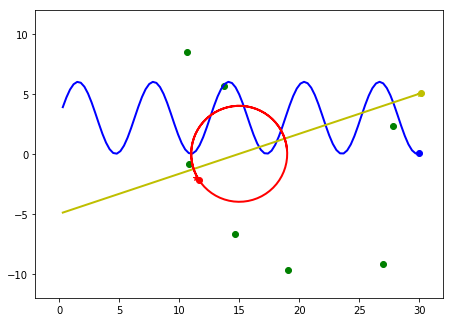

In [9]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 32), ylim=(-12, 12))

real_point1, = ax.plot([], [], 'bo', ms=6)
real_point2, = ax.plot([], [], 'yo', ms=6)
real_point3, = ax.plot([], [], 'ro', ms=6)

real_point1_est, = ax.plot([], [], 'b*', ms=6)
real_point2_est, = ax.plot([], [], 'y*', ms=6)
real_point3_est, = ax.plot([], [], 'r*', ms=6)


rand_point, = ax.plot([], [], 'go', ms=6)
obs_list_anim = np.array(obs_list)
line1, = ax.plot([], [], lw=2, color = 'b')
line2, = ax.plot([], [], lw=2, color = 'y')
line3, = ax.plot([], [], lw=2, color = 'r')

def init():
    """initialize animation"""
    
    real_point1.set_data([], [])
    real_point2.set_data([], [])
    real_point3.set_data([], [])

    real_point1_est.set_data([], [])
    real_point2_est.set_data([], [])
    real_point3_est.set_data([], [])


    rand_point.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return real_point1, real_point2, real_point3, rand_point, line1, line2, line3, real_point1_est, real_point2_est, real_point3_est

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    
    real_point1.set_data(obs_list_anim[i][0][0], obs_list_anim[i][0][1])
    real_point2.set_data(obs_list_anim[i][1][0], obs_list_anim[i][1][1])
    real_point3.set_data(obs_list_anim[i][2][0], obs_list_anim[i][2][1])

    real_point1_est.set_data(jpda_est[i][0][0, 0], jpda_est[i][0][1, 0])
    real_point2_est.set_data(jpda_est[i][1][0, 0], jpda_est[i][1][1, 0])
    real_point3_est.set_data(jpda_est[i][2][0, 0], jpda_est[i][2][1, 0])

    x , y = [], []
    for point in obs_list_anim[i][3:]:
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
    
    line1.set_data(3*time_range, 3 + 3 * np.sin(3*time_range))
    line2.set_data(3*time_range, time_range - 5)
    line3.set_data(15 + 4 * np.cos(time_range), 4 * np.sin(time_range))
    
    return real_point1, real_point2, real_point3, rand_point, real_point1_est, real_point2_est, real_point3_est

ani = animation.FuncAnimation(fig, animate, frames=len(obs_list),
                              interval=10, blit=True, init_func=init)

ani.save('video/jpda_obs_predict.mp4', fps=3)

Let's plot the figure for the tracking result